# **Poiseuille Heat Transfer Solver**

## Problem Parameters

In [81]:
#-------------------------------------------------------- GENERAL PARAMETERS ---------------------------------------------------------------------------------

H= 4E-3                                # Height between the two parallel Plates
L= 30*H                                # Channel Length, corresponding to 30 times its height H
Tw= 200.0                              # Temperature at the Walls; Will be used as a Boundary Condition later on
Tin= 300.0                             # In flow temperature; Will be also used as an inlet Boundary Condition
Ro= 1000                               # Fluid Density rho
Cp= 4180                                 # Fluid Heat Capacity at Constant Pressure
k= 0.6                                # Fluid Thermal Conductivity
U= 0.1                                 # Mean Flow Velocity
mu= 1e-3                            # Fluid Dynamic Viscosity

#-------------------------------------------------------- COMPUTATIONAL DOMAIN PARAMETERS --------------------------------------------------------------------

ncx = 160                              # Number of computational cells along x (Along the domain's Length L)
ncy = 80                               # Number of computational cells along y (Across the domain's Height H)

ncell=ncx*ncy                          # Total Cell Number
dx=L/ncx                               # Distance between Cell Centers, in the x direction
dy=H/ncy                               # Distance between Cell Centers, in the y directions

#-------------------------------------------------------- SOLVER PARAMETERS -----------------------------------------------------------------------------------

solver = "direct"                       # Choose from "gmres" (Generalized Minimal Residual Method), "direct" (direct solver, bad for sparse Matrices)
tolerance = 1e-8                       # Choose the tolerance for the solver. Does not apply to the Direct Solver
iterations = 10000                     # Choose Maximum iteration number. Does not apply to the Direct Solver

#-------------------------------------------------------- BENCHMARK CASE -------------------------------------------------------------------------------------

case = 0                               # Choose benchmark case: "1" - Case for Br = 0, viscous dissipation is turned off

## Velocity and Viscous Dissipation Functions

In [82]:
# -----------------------------------------------------------------------
# This Function Calcultes the Cell Center, necessary for other Functions
# -----------------------------------------------------------------------

def cellCenter(i):
  xcell=dx/2+(i%ncx)*dx
  ycell=dy/2+int(i/ncx)*dy-H/2
  return xcell,ycell

# -------------------------------------------------------------------------------------------------------------------------------------------------------------
# Implementation of the Poiseuille Flow Velocity Profile (Laminar, Fully-Developed) for flow between parallel plates. U is the mean velocity, defined previously
# -------------------------------------------------------------------------------------------------------------------------------------------------------------

def cellVelocity(i):
  xcell,ycell=cellCenter(i)
  return 3/2*U*(1-(2*ycell/H)**2)

# ---------------------------------------------------------------------------------------
# Function that computes viscous dissipation for Poiseuille flow between parallel plates.
# Formula: Phi = mu (du/dy)^2
# For Poiseuille flow, du/dy = -12 U/H^2 * y ; Phi = 144 mu U^2/H^4 * y^2
# ---------------------------------------------------------------------------------------

if case == 1:
  def cellVD(i):
    xcell,ycell=cellCenter(i)
    return 0
else: 
  def cellVD(i):
    xcell,ycell=cellCenter(i)
    return mu*144**U**2/H**4*ycell**2

## Finite Volume Method for Numerical Solution

In [83]:
import numpy as np 
import scipy.sparse.linalg
from numpy import linalg as LA
from scipy.sparse.linalg import gmres
from scipy.sparse import csr_matrix

# ------------------------------------------------------------
# Initialize arrays for the Finite Volume Method coefficients
# ------------------------------------------------------------

A = np.zeros((ncell,ncell))        # Coefficient Matrix A
PHI = np.zeros(ncell)              # Arbitrary Scalar Field; For this case, it corresponds to the solutions of the Temperature Field
AW = np.zeros(ncell)               # West Face Coefficient
AE = np.zeros(ncell)               # East Face Coefficient
AN = np.zeros(ncell)               # North Face Coefficient
AS = np.zeros(ncell)               # South Face Coefficient
SU = np.zeros(ncell)               # Source Term; Includes Vicous Dissipation
SP = np.zeros(ncell)               # Source Term Coefficient; Will be used for Boundary Conditions
Error_abs = np.zeros(ncell)        # Place Holder For Absolute Error
Error_rel = np.zeros(ncell)        # Place Holder For Relative Error

# ------------------------------------------------------------
# Compute convection–diffusion coefficients and source terms
# ------------------------------------------------------------
for i in range(0, ncell):
    Uy=cellVelocity(i)                              # Local Velocity for cell (i), computed from the Poiseuille Flow Velocity Profile

    # Diffusive and convective coefficients for each face

    AE[i]=k*dy/dx
    AW[i]=k*dy/dx + Ro*Cp*Uy*dy                     # includes convection term
    AS[i]=k*dx/dy
    AN[i]=k*dx/dy

    # Viscous dissipation source term for the cell
    SU[i]=cellVD(i)*dx*dy

    # Northern boundary (top wall)
    if i >= (ncell-ncx): 
        SP[i] +=-2.0*k*dx/dy                        # coefficient adjustment
        AN[i] =0                                    # no neighbor to the north
        SU[i] +=2.0*Tw*k*dx/dy                      # wall temperature contribution

    # Southern boundary (bottom wall)
    if i<ncx: 
        SP[i] += -2.0*k*dx/dy
        AS[i] = 0
        SU[i] += 2.0*Tw*k*dx/dy

    # Western boundary (inlet)
    if i % ncx == 0 :
        SP[i] +=-2.0*k*dy/dx-Ro*Cp*Uy*dy            # includes convection
        AW[i]=0
        SU[i] +=2.0*k*Tin*dy/dx+Ro*Cp*Tin*Uy*dy     # inlet temperature + convection

    # Eastern boundary (outlet)
    if (i+1) % ncx == 0 :
        SP[i] +=0
        AE[i] =0
        SU[i] +=0
    

# ------------------------------------------------------------
# Assemble coefficient matrix [A]
# ------------------------------------------------------------
for i in range(0, ncell):
    
    icw = i-1       # index of west neighbor
    ice = i+1       # index of east neighbor
    icn = i+ncx     # index of north neighbor
    ics = i-ncx     # index of south neighbor

    # Fill matrix with neighbor contributions
    if i>=ncx:                                      # not on the first row
      A[i,ics]=-AS[i] 
    if i % ncx != 0 :                               # not on the first column       
      A[i,icw]=-AW[i] 
    if (i+1) % ncx != 0 :                           # not on the last column
      A[i,ice]=-AE[i] 
    if i < (ncell-ncx):                             # not on the last Row
      A[i,icn]=-AN[i] 
    
    # Diagonal coefficient (ap) for the control volume
    A[i,i]=AW[i]+AE[i]+AN[i]+AS[i]-SP[i]

# ------------------------------------------------------------
# Solve the linear system A · PHI = SU
# ------------------------------------------------------------

if solver == "gmres":
  A_sparse = csr_matrix(A)                                          # Converts matrix A in a sparse format   
  phi, info = gmres(A_sparse, SU, rtol=tolerance, maxiter=iterations)
  PHI = phi   # Computes the temperature field using Conjugate Gradient Solver
  if info == 0:
    print("GMRES converged.")
  elif info > 0:
    print(f"GMRES did not converge after {iterations} iterações.")
  else:
    print("GMRES found an error.")

elif solver == "direct":
  A_inverse = np.linalg.inv(A)                                      # Invert the coefficient matrix (not very efficient for large problems)
  PHI = np.dot(A_inverse,SU)                                        # Compute the temperature field using a direct solver

# ------------------------------------------------------------
# Output results
# ------------------------------------------------------------
print("Maximum Temperature:",max(PHI))
print("Minimum Temperature:",min(PHI))

Maximum Temperature: 300.00000001122066
Minimum Temperature: 202.63418172396206


# Post-Processing -- Temperature Field

In [84]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def vec2Grid(var,nx,ny):

    """
    Converts the 1D solution vector (PHI) into a 2D grid (z) for plotting.

    Parameters:
        var (array): Flattened array with the solution (temperature).
        nx (int): Number of cells in x-direction.
        ny (int): Number of cells in y-direction.

    Returns:
        z (2D array): Temperature values arranged in (x, y) grid.
    """

    z = np.zeros((nx,ny))
    for i in range(0, ncell):
        z[i%ncx,int(i/ncx)]=var[i]
    return z

# ------------------------------------------------------------
# Plot configuration
# ------------------------------------------------------------
plt.rcParams.update({'font.size': 150})    # Global font size for plot

# ------------------------------------------------------------
# Create grid for plotting (normalized coordinates)
# ------------------------------------------------------------
x, y = np.mgrid[slice(0, L+1e-10 , dx),slice(-H/2.0, H/2.0+1e-10, dy)]

x=x/L                                      # Normalize x by channel Length                   
y=y/H                                      # Normalize y by channel Height

# Figure scale parameters
figScl = 10
vertMag = 100                              # exaggerates vertical dimension for better visualization

fig, axs = plt.subplots(1, 1,figsize=(figScl*L/H,vertMag*figScl*H/L))

# ------------------------------------------------------------
# Process data and prepare for contour plot
# ------------------------------------------------------------
z = vec2Grid(PHI,ncx,ncy)                  # map PHI into 2D grid
Var_min, Var_max = min(PHI), max(PHI)      # temperature range

# ------------------------------------------------------------
# Create filled contour plot
# ------------------------------------------------------------
c = axs.pcolor(x, y, z, cmap='jet', vmin=Var_min, vmax=Var_max)

# Label axes and title
axs.set(xlabel='x/L', ylabel='y/H',
       title='Temperature Field in Poiseuille Flow')

# Add colorbar with discrete boundaries
bound=np.linspace(int(min(PHI)), int(max(PHI)+0.5), 11, endpoint=True)
fig.colorbar(c, label='Temperature [ºC]', boundaries=bound)

# Save and show figure
fig.savefig("Contour.png")
plt.show()



# Post-Processing -- Temperature Profile Evolution

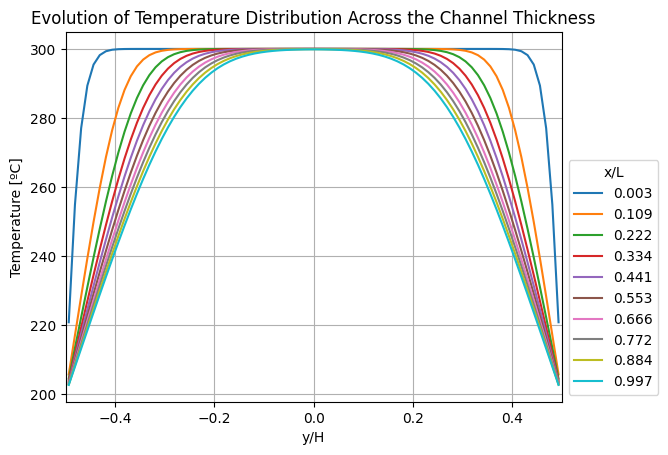

In [85]:
import matplotlib
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Plot configuration
# ------------------------------------------------------------
plt.rcParams.update({'font.size': 10})   # Set font size for the plot
fig, ax = plt.subplots()                 # Create a new figure and axis

# ------------------------------------------------------------
# Select columns (x positions) to extract temperature profiles
# ------------------------------------------------------------
# Option 1: Manually select specific columns
# plotClmn = [0, int(0.25*ncx), int(0.5*ncx), ncx-1]

# Option 2: Automatically select evenly spaced columns (used here)
plotClmn = np.linspace(0, ncx-1, 10, endpoint=True, dtype=int)

# ------------------------------------------------------------
# Create y-axis (normalized by channel height)
# ------------------------------------------------------------
# Note: we add dy/2 so the points correspond to cell centers
yLine = (np.arange(-H/2 + dy/2.0, H/2, dy)) / H

# ------------------------------------------------------------
# Plot temperature profiles for the selected x positions
# ------------------------------------------------------------
for i in plotClmn:
    # Normalized x-coordinate for legend
    xLabel = int((dx/2 + (i % ncx) * dx) / L * 1000 + 0.5) / 1000
    zLine = z[i, :, None]  # Temperature values for that column
    ax.plot(yLine, zLine, label=xLabel)

# ------------------------------------------------------------
# Format the plot
# ------------------------------------------------------------
ax.set(xlabel='y/H',
       ylabel='Temperature [ºC]',
       title='Evolution of Temperature Distribution Across the Channel Thickness')

ax.grid()
ax.legend(loc='lower left',
          bbox_to_anchor=(1, 0.0),
          title='x/L')  # Legend indicates positions along the channel

# Set y-axis limits
ax.set_xlim([-0.5, 0.5])

# Save and show figure
fig.savefig("Temperature_Profiles.png")
plt.show()